#### Loran-c Reference Signal
신호의 패턴 그룹을 찾기 위해, 패턴의 기준이 되는 윈도우가 필요함.  
이를 구현하기 위해, 기본적인 Loran-c 를 코드로 구현하고, loran chain 에 따라 Reference window를 출력 및 저장하도록 구현하였음.

##### 라이브러리 로드

`numpy` : 배열이나 행렬연산 기능을 모아 놓은 라이브러리  
`matplotlib` : 데이터 시각화에 쓰이는 기능들을 모아 놓은 라이브러리  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##### Loran-c 신호 생성
레퍼런스 [1, 2]를 참고하여 loran-c 신호를 구현하였다. 아래와 같이, 기본적인 변수들을 설정하고, 설정된 값을 통해 **100khz**의 loran-c 신호를 구현하였다. 구현된 신호는 300μs 기준으로 구현하였고, Fast Fourier Transform을 통해, 주파수 분석을 진행하였다. 또한 본 신호를 1ms 기준으로는 어떻게 볼 수 있는지 구현하였다. 구현된 신호는 `matplotlib`를 통해 시각화를 진행하였고, 진행된 결과는 6번 셀에서 확인할 수 있다.

- Reference  
1) [Precise Loran-C Signal Acquisition Based onEnvelope Delay Correlation Method](https://www.mdpi.com/1424-8220/20/8/2329)  
2) [Suppression of Continuous Wave Interference in Loran-CSignal Based on Sparse Optimization Using Tunable Q-Fact or Wavelet Transform and Discrete Cosine Transform](https://www.mdpi.com/1424-8220/21/21/7153)

In [2]:
# variable
f = 100e3
time_interval = 1/f
tau = 0
pc = 0


In [3]:
# loran-c 300
t = np.linspace(0, 300, 30000)

envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)

In [4]:
# Loran-c 300 fft
N = len(s)
k = np.arange(N)
T = N/f
freq = k / T
freq = freq[range(int(N/2))]

s_fft = np.fft.fft(s)
sf = s_fft / N
sf = sf[range(int(N/2))]

sf = abs(sf)
normalized_sf = (sf - np.min(sf)) / (np.max(sf) - np.min(sf))


In [5]:

# loran-c 1000
t_2 = np.linspace(0, 1000, 30000)

envelope_2 = (t_2-tau)**2*np.exp(-2*(t_2-tau)/65)
normalized_e_2 = (envelope_2 - np.min(envelope_2))/(np.max(envelope_2)-np.min(envelope_2))
s_2 = normalized_e_2 *np.sin(2*np.pi*f*t_2*1e-6 + pc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


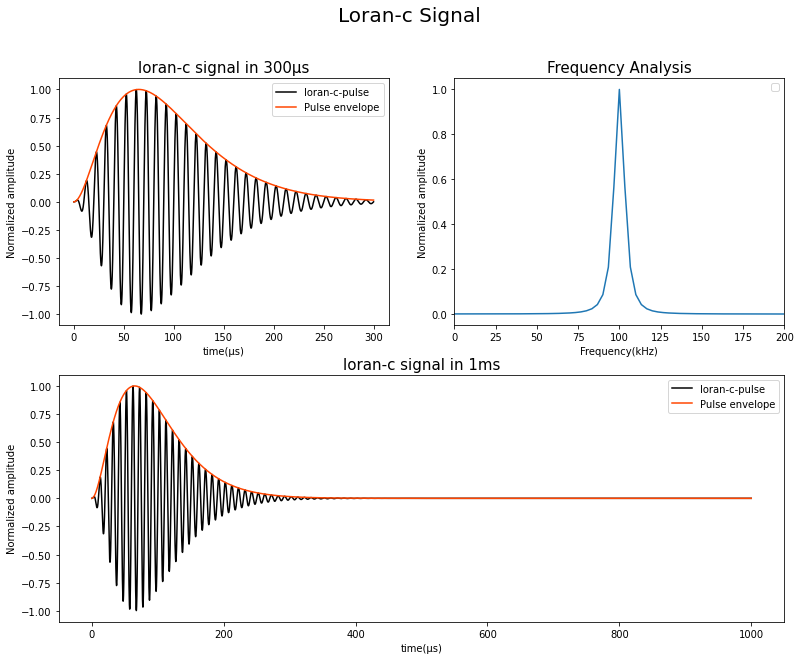

In [6]:
fig = plt.figure(figsize=(13, 10))
plt.suptitle("Loran-c Signal", fontsize=20)

ax1 = plt.subplot2grid((2,2), 
                       (0,0), 
                       fig=fig)

ax2 = plt.subplot2grid((2,2), 
                       (0,1), 
                       fig=fig)

ax3 = plt.subplot2grid((2, 2),
                       (1, 0),
                       colspan=2,
                       fig=fig)

ax1.plot(t, s, 'k', label='loran-c-pulse')
ax1.plot(t, normalized_e, 'orangered', label='Pulse envelope')
ax1.set_title("loran-c signal in 300μs", fontsize=15)
ax1.set_ylabel("Normalized amplitude", fontsize=10)
ax1.set_xlabel("time(μs)", fontsize=10)
ax1.legend()

ax2.plot(freq[:200], abs(normalized_sf[:200]))
ax2.set_xlim(0, 200)
ax2.set_title("Frequency Analysis", fontsize=15)
ax2.set_ylabel("Normalized amplitude", fontsize=10)
ax2.set_xlabel("Frequency(kHz)", fontsize=10)
ax2.legend()

ax3.plot(t_2, s_2, 'k', label='loran-c-pulse')
ax3.plot(t_2, normalized_e_2, 'orangered', label='Pulse envelope')
ax3.set_title('loran-c signal in 1ms', fontsize=15)
ax3.set_ylabel("Normalized amplitude", fontsize=10)
ax3.set_xlabel("time(μs)", fontsize=10)
ax3.legend()

plt.show()

#### generate master / slave window
`gen_master_window()`에서는 master의 reference signal을 생성한다. tau값을 증가시키면서 총 10ms(10,000μs)의 master reference signal을 생성한다. 본 신호는 1ms 간격으로 loran-c 신호를 출력하고, 8번째 loran-c 신호가 출력 된 이후 2ms 이후에 마지막으로 loran-c 신호를 출력한다. `gen_slave_window()`는 `gen_master_window()`와 동일한 기능을 하지만, 차이점은 1ms 간격으로 loran-c 신호를 총 8번만 출력한다는 점에 있다.  
생성된 master reference siganl과 slave reference signal 확인을 위해, 신호를 plot 하여 reference signal이 잘 생성되었는지 확인하였다. 두 신호를 정확히 비교하기 위해, x축의 범위를 [-500, 10500]으로 고정하였다.

`gen_master_window()`

In [7]:
def gen_master_window():
    
    freq = 100e3
    tau = 0
    master_window = np.array([])
    master_window_e = np.array([])
    timespace = np.array([])

    for i in range(0, 10):
        
        t = np.linspace(tau, tau+1000, 30000)
        
        if i == 8:
            normalized_e = np.zeros(shape=(30000, ))
            s = np.zeros(shape=(30000, ))
        
        else:
            envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
            normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
            s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)
        
        timespace = np.append(timespace[:-1], t)
        master_window = np.append(master_window[:-1], s)
        master_window_e = np.append(master_window_e[:-1], normalized_e)
        
        #print("tau :", tau)
        #print("length of time space :", len(timespace))
        #print("length of master_window :", len(master_window))
        #print("length of master_window_e :", len(master_window_e))
        
        tau += 1000
        
    return timespace, master_window, master_window_e
        

In [8]:
def gen_slave_window():
    freq = 100e3
    tau = 0
    slave_window = np.array([])
    slave_window_e = np.array([])
    timespace = np.array([])

    for i in range(0, 8):
        
        t = np.linspace(tau, tau+1000, 30000)
 
        envelope = (t-tau)**2*np.exp(-2*(t-tau)/65)
        normalized_e = (envelope - np.min(envelope))/(np.max(envelope)-np.min(envelope))
        s = normalized_e *np.sin(2*np.pi*f*t*1e-6 + pc)
        
        timespace = np.append(timespace[:-1], t)
        slave_window = np.append(slave_window[:-1], s)
        slave_window_e = np.append(slave_window_e[:-1], normalized_e)
        
        #print("tau :", tau)
        #print("length of time space :", len(timespace))
        #print("length of slave_window :", len(slave_window))
        #print("length of slave_window_e :", len(slave_window_e))
        
        tau += 1000
        
    return timespace, slave_window, slave_window_e

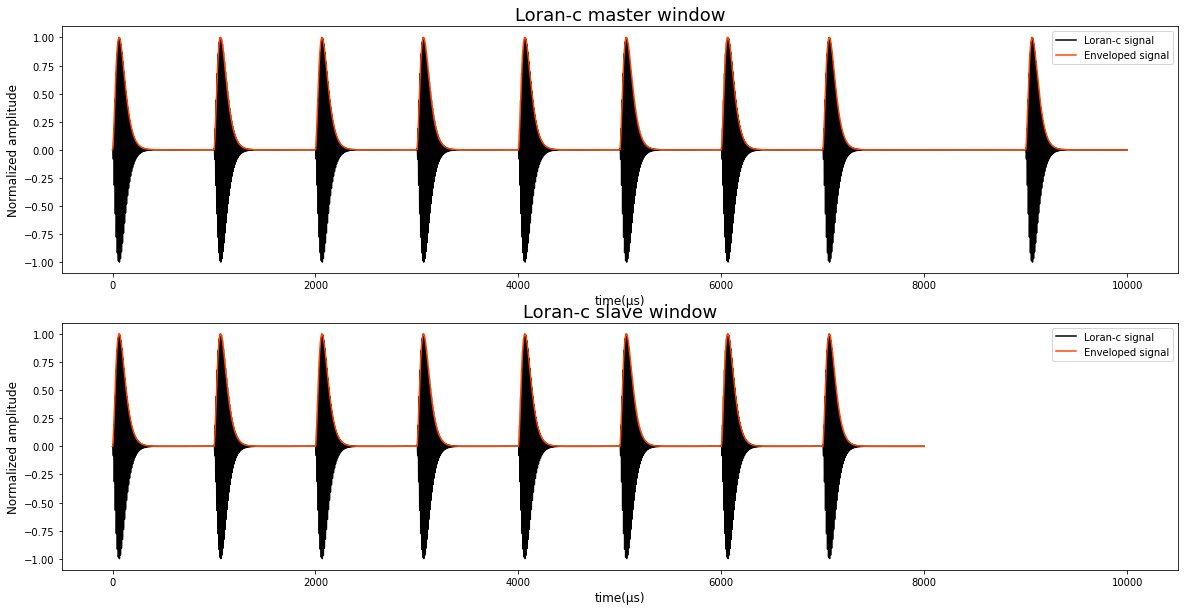

In [9]:
# Generate master and slave window
timespace_m, master_window, master_window_e = gen_master_window()
timespace_s, slave_window, slave_window_e = gen_slave_window()

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(timespace_m, master_window, 'k', label='Loran-c signal')
axes[0].plot(timespace_m, master_window_e, 'orangered', label='Enveloped signal')
axes[0].set_xlim(-500, 10500)
axes[0].set_title("Loran-c master window", fontsize=18)
axes[0].set_xlabel("time(μs)", fontsize=12)
axes[0].set_ylabel("Normalized amplitude", fontsize=12)
axes[0].legend(loc='upper right')

axes[1].plot(timespace_s, slave_window, 'k', label='Loran-c signal')
axes[1].plot(timespace_s, slave_window_e, 'orangered', label='Enveloped signal')
axes[1].set_xlim(-500, 10500)
axes[1].set_title("Loran-c slave window", fontsize=18)
axes[1].set_xlabel("time(μs)", fontsize=12)
axes[1].set_ylabel("Normalized amplitude", fontsize=12)
axes[1].legend(loc='upper right')

plt.show()

##### merge_signal_by_id
`merge_signal_by_id`는 생성한 master signal과 slave signal을 기반으로, `chain-id`에 따라서 reference signal을 생성하고 관련 값들을 return해주는 기능을 한다. 함수 내에서 id는 `default=0`으로 고정되어 있고, id에 따라, loran chain의 이름, 송신국 정보, emission time의 정보를 담고있다. 현재 추가되어 있는 id는 `7430 China North Sea Chain`, `8390 China East Sea Chain`, `9930 East Asia chain` 이고, 추후에 라이브러리로 배포시에는, `Mega-pulse` 에서 제공하는 loran-chain-information을 참고하여 id들을 추가할 예정이다.  
`merge_siignal_by_id`는 `id`, `timespace`, `master_window`, `master_window_e`, `timpsace_s`, `slave_window`, `slave_window_e` 의 인자를 필요로 한다. **id외에는 `gen_master_window()`와 `gen_slave_window()`를 실행한 결과들을 그대로 넘겨주면 되기 때문에, 추후에는 id만을 핸들링하여, reference signal을 얻을 수 있다.**  

아래 코드에서는 신호들을 ploting하는 부분들이 있는데 이는 본 코드에서 확인을 위한 작업일 뿐, merge_signal_by_id()에는 포함되지 않는 기능이다.

In [10]:
def merge_signal_by_id(id=0, timespace_m=0, master_window=0, master_window_e=0, timespace_s=0, slave_window=0, slave_window_e=0 ):
    
    if id==7430:
        id_chain = '7430 China North Sea chain'
        sending_station = ['master_Rongcheng', 'slave_Xuancheng', 'slave_Helong']
        sending_timing = [10000, 13459.7, 30852.32]
    
    elif id==8390:
        id_chain = '8390 China East Sea chain'
        sending_station = ['master_Xuancheng', 'slave_Raoping', 'slave_Rongcheng']
        sending_timing = [10000, 13795.52, 31459.70]
    
    elif id==9930:
        id_chain = '9930 East Asia chain'
        sending_station = ['master_Pohang', 'slave_Kwangju', 'slave_Ussuriisk', 'slave_Incheon']
        sending_timing = [10000, 11946.97, 54162.44, 81352]
    
    else:
        print("id error occured")
        return
    
    # variables
    start_time = 0
    timespace = np.array([])
    signal = np.array([])
    signal_e = np.array([])
    #print("timspace_s size : ", len(timespace_s))
    #print("slave_window size : ", len(slave_window))
    #print("salve_window_e size : ", len(slave_window_e))
    
    for station, end_time in zip(sending_station, sending_timing):
        
        status, site = station.split('_')
        print("status, site :", status, site)
        if status=='master':
            print("master process")
            timespace = np.append(timespace, timespace_m)
            signal = np.append(signal, master_window)
            signal_e = np.append(signal_e, master_window_e)
            
            start_time = end_time
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            print("master process over; start_time :", start_time)
            print()
        
        elif status=='slave':
            print("slave process; end time :", end_time)
            time_interval = end_time-start_time
            
            temp = np.linspace(start_time, end_time, int(30*(time_interval)))
            temp_signal = np.zeros(shape=(int(30*time_interval), ))
            print("shape of temp :", temp.shape, "shape of temp_signal :", temp_signal.shape)
            
            timespace = np.append(timespace, temp[1:])
            signal = np.append(signal, temp_signal[1:])
            signal_e = np.append(signal_e, temp_signal[1:])
            
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            
            start_time = end_time
            print(start_time)            
            temp = start_time + timespace_s
            
            timespace = np.append(timespace, temp)
            signal = np.append(signal, slave_window)
            signal_e = np.append(signal_e, slave_window_e)
            
            start_time = timespace[-1]
            print("length of timespace :", len(timespace), "|| length of signal :", len(signal), "|| length of signal_e :", len(signal_e))
            print("slave process over; start_time :", start_time)
            print()
    
    end_time = id*10
    time_interval = end_time - start_time
    temp = np.linspace(start_time, end_time, int(30*time_interval))
    temp_signal = np.zeros(shape=(int(30*time_interval), ))
    
    timespace = np.append(timespace, temp[1:])
    signal = np.append(signal, temp_signal[1:])
    signal_e = np.append(signal_e, temp_signal[1:])
    """
    plt.figure(figsize=(20, 5))
    plt.plot(timespace, signal, 'k', label='Loran-c signal')
    #plt.plot(timespace, signal, 'k')
    plt.plot(timespace, signal_e, 'orangered', label='Enveloped signal')
    #plt.plot(timespace, signal_e, 'orangered')
    plt.vlines(end_time, -1, 1, color='green', linestyles='--')
    plt.text(end_time+1000, -0.2, 'end\nof\nsignal\nwindow\n\n'+str(end_time)+'μs', color='green', weight='bold')
    plt.xlim(-4000, end_time + 7000)
    plt.title('Reference signal : '+id_chain, fontsize=17)
    plt.xlabel('time(μs)', fontsize=13)
    plt.ylabel('Normalized Amplitude', fontsize=13)
    plt.legend(loc='upper right')
    plt.show()
    """
    return timespace, signal, signal_e, id_chain
    

status, site : master Rongcheng
master process
length of timespace : 299991 || length of signal : 299991 || length of signal_e : 299991
master process over; start_time : 10000

status, site : slave Xuancheng
slave process; end time : 13459.7
shape of temp : (103791,) shape of temp_signal : (103791,)
length of timespace : 403781 || length of signal : 403781 || length of signal_e : 403781
13459.7
length of timespace : 643774 || length of signal : 643774 || length of signal_e : 643774
slave process over; start_time : 21459.7

status, site : slave Helong
slave process; end time : 30852.32
shape of temp : (281778,) shape of temp_signal : (281778,)
length of timespace : 925551 || length of signal : 925551 || length of signal_e : 925551
30852.32
length of timespace : 1165544 || length of signal : 1165544 || length of signal_e : 1165544
slave process over; start_time : 38852.32

status, site : master Xuancheng
master process
length of timespace : 299991 || length of signal : 299991 || length o

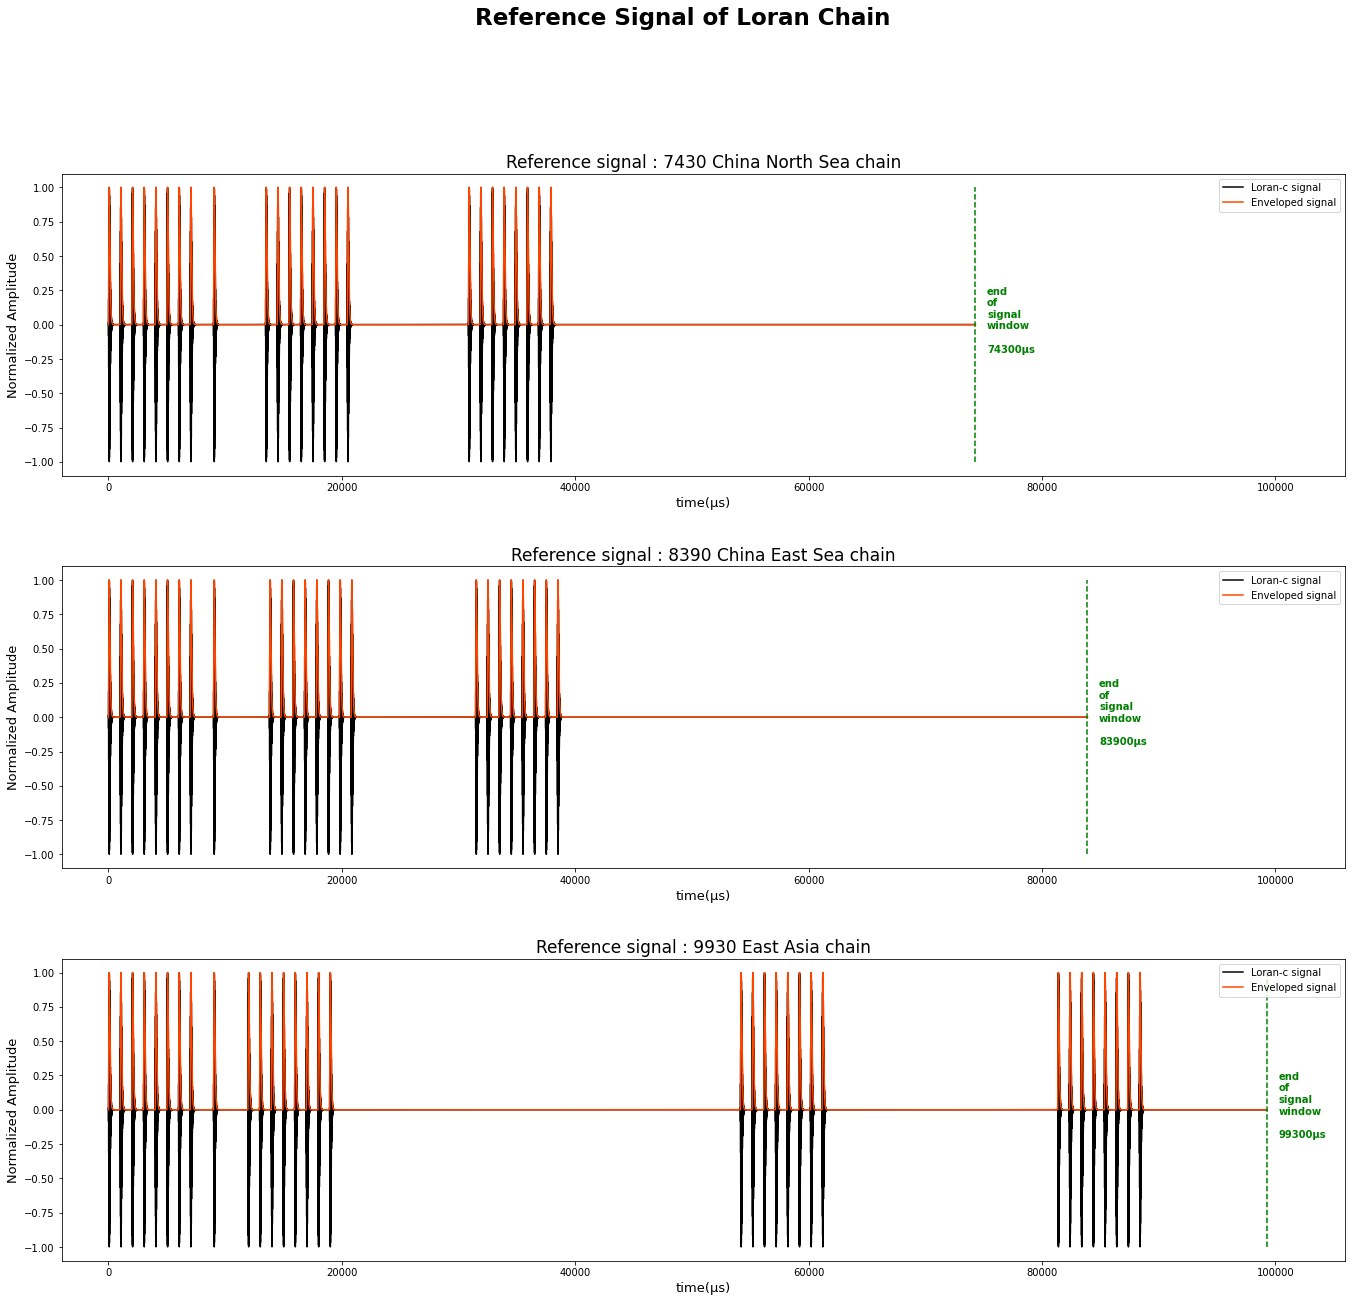

In [11]:
id_list = [7430, 8390, 9930]
merged_timespace = np.array([])
merged_signal = np.array([])

fig, axes = plt.subplots(3, 1, figsize=(23, 20))

plt.suptitle("Reference Signal of Loran Chain", fontsize=23, weight='bold', ha='center', va='bottom')

axes_num = 0


for id_ in id_list:
    temp_time, temp_signal, temp_signal_e, id_chain = merge_signal_by_id(id_, timespace_m, master_window, master_window_e, timespace_s, slave_window, slave_window_e)
    
    # Line plot : signal data, enveloped signal
    axes[axes_num].plot(temp_time, temp_signal, 'k', label='Loran-c signal')
    axes[axes_num].plot(temp_time, temp_signal_e, 'orangered', label='Enveloped signal')
    
    # Line for checking end-point
    axes[axes_num].vlines(id_*10, -1, 1, color='green', linestyles='--')
    
    # Text for checking end-point
    axes[axes_num].text(id_*10+1000, -0.2, 'end\nof\nsignal\nwindow\n\n'+str(id_*10)+'μs', color='green', weight='bold')
    
    # Plot settings : xlim, xlabel, ylabel, legend
    axes[axes_num].set_xlim(-4000, 106000)
    axes[axes_num].set_title('Reference signal : '+ id_chain, fontsize=17)
    axes[axes_num].set_xlabel('time(μs)', fontsize=13)
    axes[axes_num].set_ylabel('Normalized Amplitude', fontsize=13)
    axes[axes_num].legend(loc='upper right')
    
    axes_num += 1

plt.subplots_adjust(hspace=0.3)

plt.show()